# CS 412 - Voltron
---


Ada Canoğlu <br>
İrem Gezgen <br>
Nehir İlkim Gönençer <br>
Aslıhan Hamzaoğlu <br>

Please Select the TPU v2 Runtime Type Before Running the Notebook Because Of the Large Memory Required

In [ ]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.8 MB/s eta 0:00:00


In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.0/616.0 kB 35.3 MB/s eta 0:00:00


Data Preprocessing
---


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Ensure NLTK resources are available
nltk.download('stopwords')
nltk.download('wordnet')

# Load data
file_path = 'bugs-train.csv'
data = pd.read_csv(file_path)

# Text cleaning function with stop words removal and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Lemmatize and remove stop words
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Apply text cleaning
data['cleaned_summary'] = data['summary'].apply(clean_text)

Data Analysis
---


In [ ]:
from collections import Counter

# Tokenize the text
all_text = ' '.join(data['cleaned_summary'])
words = all_text.split()

# Get the word frequency distribution
word_freq = Counter(words)

# Total number of unique words
total_unique_words = len(word_freq)

# Display the top 30 most common words
top_30_common_words = word_freq.most_common(30)

total_unique_words, top_30_common_words

(94655,
 [('crash', 15552),
  ('assertion', 8694),
  ('intermittent', 8248),
  ('failure', 6592),
  ('firefox', 6525),
  ('test', 6191),
  ('window', 5223),
  ('add', 5054),
  ('use', 4796),
  ('remove', 4762),
  ('error', 4668),
  ('build', 4333),
  ('page', 4249),
  ('doesnt', 3910),
  ('make', 3897),
  ('file', 3768),
  ('code', 3760),
  ('application', 3714),
  ('support', 3585),
  ('element', 3539),
  ('image', 3252),
  ('text', 3210),
  ('event', 3161),
  ('using', 3147),
  ('work', 2994),
  ('fix', 2872),
  ('content', 2863),
  ('fails', 2758),
  ('implement', 2741),
  ('x', 2723)])

In [ ]:
# Severity mapping
severity_mapping = {
    'enhancement': 0,
    'minor': 1,
    'normal': 2,
    'major': 3,
    'blocker': 4,
    'critical': 5,
    'trivial': 6
}

data['severity'] = data['severity'].map(severity_mapping)

Vectorization
---

Doc2Vec

In [ ]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Step 1: Tokenize the text data
data['tokens'] = data['summary'].apply(gensim.utils.simple_preprocess)

# Step 2: Create tagged documents
tagged_documents = [TaggedDocument(words=row['tokens'], tags=[i]) for i, row in data.iterrows()]

# Step 3: Train a Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=300, window=5, min_count=2, workers=-1, epochs=40)
doc2vec_model.build_vocab(tagged_documents)
doc2vec_model.train(tagged_documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Step 4: Transform the text data into vectors
data['doc2vec_vector'] = data['tokens'].apply(lambda x: doc2vec_model.infer_vector(x))

Word2Vec

In [ ]:
from gensim.models import Word2Vec

# Fill NaN values with an empty string
data['cleaned_summary'] = data['cleaned_summary'].fillna('')

# Convert all non-string values to strings (just in case)
data['cleaned_summary'] = data['cleaned_summary'].astype(str)

# Tokenize the text for Word2Vec
tokenized_text = [text.split() for text in data['cleaned_summary']]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=300, window=5, min_count=1, workers=-1)

# Function to get average Word2Vec embeddings for a document
def get_w2v_embeddings(text):
    words = text.split()
    embeddings = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(embeddings) == 0:
        return np.zeros(300)
    return np.mean(embeddings, axis=0)

data['w2v_embeddings'] = data['cleaned_summary'].apply(get_w2v_embeddings)

TF-IDF

In [ ]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=94655,
    use_idf=True,
)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_summary'])

# Convert TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

Combining Features
---

In [ ]:
data = pd.concat([data[['severity']],
                               pd.DataFrame(data['doc2vec_vector'].tolist()),
                               pd.DataFrame(data['w2v_embeddings'].tolist()),
                               tfidf_df], axis=1, join='inner')

In [ ]:
y = data.iloc[:, 0]

In [ ]:
data = data.drop('severity', axis=1)

In [ ]:
data.columns = range(data.shape[1])

# Convert X column names to strings
data.columns = data.columns.astype(str)

Training the model for feature extraction
---

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report


# Train an initial XGBoost model to get feature importances
xgb_model_feature = xgb.XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    learning_rate=0.05,
    n_estimators=100,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=1
)

# Train the XGBoost model
xgb_model_feature.fit(data, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

Saving and retrieving the model

In [ ]:
import joblib
joblib.dump(xgb_model_feature, 'xgb_model_high_dim.pkl') # Save the model with all dimensions

In [ ]:
import joblib
xgb_model_feature = joblib.load('xgb_model_high_dim.pkl') # Load the model with all dimensions

Selecting the top 500 most important features

In [ ]:
importances = xgb_model_feature.feature_importances_

# Get indices of top 500 features
top_500_indices = np.argsort(importances)[-500:]

print(top_500_indices)

# Ensure data is a Numpy array
data_array = data.values if isinstance(data, pd.DataFrame) else data

# Select the top 500 features
X_train_selected = data_array[:, top_500_indices]

import gc

# Delete the DataFrame - to free up memory space
del data_array

# Run garbage collector
gc.collect()

[39226   526 39517   529   420   321   444   423 64213    49 82818   514
 19045 62511   496   395   437   599 27558 15017   504   400 83204   495
   314 24222 25781 84146   562   505   477 80189 81250 25377 12953 50441
 89176   469 16590   320   370 27998 48136   376   346  6589 15025 79674
  8492 28163 27523   341 35113 56304   418 89490   300   256 79749 41399
 32034   467   579 27337 22419 89639 66967 35835 61742   425 95134   443
   403   518   535 11793 18370 54201 81994 70629 54931 15753 88102   421
   354 52212 91107 18320 88347 51424   355   396 17167   524   491 76156
 31013 14757   530 73569  9528 47616 18334 19664  1697 51581   381 27672
 12931   488 30723   571 23686 64874 25034   326 20717 82479 18463 80348
   318   566 35743  2797 90131 69659   532   594 87846 90106   347   303
  9753 26297 25526 93955 18016  2525 88072 21953   558 24815 59863 67599
   359 91570   568 85586   466 15807 82448 88773 75035 76785  8645   508
 86302 61751 51798 73682   434 89526 82522 87748 26

0

Performing Bayesian optimization for tuning hyperparameters
---

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score

# You may need to split your data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_selected, y, test_size=0.2, random_state=42)

def objective(trial):
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 80, 150),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_int('gamma', 0, 5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.01, 10),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 0.1, 8)
    }

    model = xgb.XGBClassifier(
        objective='multi:softmax',
        use_label_encoder=False,
        **param
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    precision = precision_score(y_val, preds, average='macro')

    # Print the results for each trial
    print(f"Trial {trial.number} - Parameters: {param} - Accuracy: {accuracy} - Macro Avg Precision: {precision}")

    return precision

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best parameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

[I 2024-06-04 15:50:57,713] A new study created in memory with name: no-name-6acc4b8b-c718-4117-b78a-83e966ad0c84
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0

Trial 0 - Parameters: {'learning_rate': 0.052571549618282046, 'n_estimators': 129, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.5445279989110292, 'colsample_bytree': 0.9538429283770278, 'gamma': 5, 'reg_alpha': 0.25150828926596447, 'reg_lambda': 0.3121088057750968, 'scale_pos_weight': 4.632656032047241} - Accuracy: 0.8583125 - Macro Avg Precision: 0.47284811682517247


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:51:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 15:51:43,490] Trial 1 finished with value: 0.6434603310843902 and parameters: {'learning_rate': 0.02808136713461771, 'n_estimators': 124, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.6658486803055184, 'colsample_bytree': 0.6326263072995133, 'gamma': 0, 'reg_alpha': 0.08584846842814425, 'reg_lambda': 0.5058640647846574, 'scale_pos_weight': 5.613059649768802}. Best is trial 1 with value: 0.6434603310843902.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest

Trial 1 - Parameters: {'learning_rate': 0.02808136713461771, 'n_estimators': 124, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.6658486803055184, 'colsample_bytree': 0.6326263072995133, 'gamma': 0, 'reg_alpha': 0.08584846842814425, 'reg_lambda': 0.5058640647846574, 'scale_pos_weight': 5.613059649768802} - Accuracy: 0.85703125 - Macro Avg Precision: 0.6434603310843902


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:51:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 15:52:04,701] Trial 2 finished with value: 0.48909056622289304 and parameters: {'learning_rate': 0.057270299011239555, 'n_estimators': 143, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.796130539115962, 'colsample_bytree': 0.9518732726119128, 'gamma': 5, 'reg_alpha': 7.568916134558459, 'reg_lambda': 0.7136677381098746, 'scale_pos_weight': 7.512069137028508}. Best is trial 1 with value: 0.6434603310843902.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_

Trial 2 - Parameters: {'learning_rate': 0.057270299011239555, 'n_estimators': 143, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.796130539115962, 'colsample_bytree': 0.9518732726119128, 'gamma': 5, 'reg_alpha': 7.568916134558459, 'reg_lambda': 0.7136677381098746, 'scale_pos_weight': 7.512069137028508} - Accuracy: 0.8571875 - Macro Avg Precision: 0.48909056622289304


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:52:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 15:52:43,235] Trial 3 finished with value: 0.8319709320495624 and parameters: {'learning_rate': 0.06697981607477009, 'n_estimators': 144, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6143993174930544, 'colsample_bytree': 0.5525478737352858, 'gamma': 0, 'reg_alpha': 0.18058498701942438, 'reg_lambda': 0.062409780333126046, 'scale_pos_weight': 3.5289624790265495}. Best is trial 3 with value: 0.8319709320495624.


Trial 3 - Parameters: {'learning_rate': 0.06697981607477009, 'n_estimators': 144, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6143993174930544, 'colsample_bytree': 0.5525478737352858, 'gamma': 0, 'reg_alpha': 0.18058498701942438, 'reg_lambda': 0.062409780333126046, 'scale_pos_weight': 3.5289624790265495} - Accuracy: 0.86025 - Macro Avg Precision: 0.8319709320495624


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 4 - Parameters: {'learning_rate': 0.08991378152559787, 'n_estimators': 83, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7875962770145171, 'colsample_bytree': 0.5659099027893705, 'gamma': 2, 'reg_alpha': 6.705316879997907, 'reg_lambda': 0.017771721141819536, 'scale_pos_weight': 1.8661800134075126} - Accuracy: 0.85728125 - Macro Avg Precision: 0.49640899177825876


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:52:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 15:53:24,502] Trial 5 finished with value: 0.46777785239230824 and parameters: {'learning_rate': 0.01174674645621331, 'n_estimators': 82, 'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.7218174192354034, 'colsample_bytree': 0.9253341437521003, 'gamma': 5, 'reg_alpha': 0.017092101758304924, 'reg_lambda': 0.043029899123205685, 'scale_pos_weight': 7.609460860865313}. Best is trial 3 with value: 0.8319709320495624.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: sugg

Trial 5 - Parameters: {'learning_rate': 0.01174674645621331, 'n_estimators': 82, 'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.7218174192354034, 'colsample_bytree': 0.9253341437521003, 'gamma': 5, 'reg_alpha': 0.017092101758304924, 'reg_lambda': 0.043029899123205685, 'scale_pos_weight': 7.609460860865313} - Accuracy: 0.85790625 - Macro Avg Precision: 0.46777785239230824


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:53:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 15:53:54,512] Trial 6 finished with value: 0.48161898816476123 and parameters: {'learning_rate': 0.014133306551288709, 'n_estimators': 135, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.8964756157312127, 'colsample_bytree': 0.5909254782216419, 'gamma': 3, 'reg_alpha': 8.131915266505128, 'reg_lambda': 0.04473611790418603, 'scale_pos_weight': 0.9597014892808404}. Best is trial 3 with value: 0.8319709320495624.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: sugge

Trial 6 - Parameters: {'learning_rate': 0.014133306551288709, 'n_estimators': 135, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.8964756157312127, 'colsample_bytree': 0.5909254782216419, 'gamma': 3, 'reg_alpha': 8.131915266505128, 'reg_lambda': 0.04473611790418603, 'scale_pos_weight': 0.9597014892808404} - Accuracy: 0.85784375 - Macro Avg Precision: 0.48161898816476123


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:53:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 15:54:19,361] Trial 7 finished with value: 0.49916557918768517 and parameters: {'learning_rate': 0.010229436647363734, 'n_estimators': 106, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.7866073012150081, 'colsample_bytree': 0.506819313483891, 'gamma': 3, 'reg_alpha': 2.41050163037508, 'reg_lambda': 6.847102111394842, 'scale_pos_weight': 5.195573150865807}. Best is trial 3 with value: 0.8319709320495624.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_lo

Trial 7 - Parameters: {'learning_rate': 0.010229436647363734, 'n_estimators': 106, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.7866073012150081, 'colsample_bytree': 0.506819313483891, 'gamma': 3, 'reg_alpha': 2.41050163037508, 'reg_lambda': 6.847102111394842, 'scale_pos_weight': 5.195573150865807} - Accuracy: 0.8568125 - Macro Avg Precision: 0.49916557918768517


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:54:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 15:54:35,805] Trial 8 finished with value: 0.6185364354545431 and parameters: {'learning_rate': 0.07751506784784057, 'n_estimators': 90, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.5753483568214366, 'colsample_bytree': 0.8317372801357007, 'gamma': 5, 'reg_alpha': 0.015150443524383871, 'reg_lambda': 0.16557730485926136, 'scale_pos_weight': 1.3499885217737035}. Best is trial 3 with value: 0.8319709320495624.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: sugge

Trial 8 - Parameters: {'learning_rate': 0.07751506784784057, 'n_estimators': 90, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.5753483568214366, 'colsample_bytree': 0.8317372801357007, 'gamma': 5, 'reg_alpha': 0.015150443524383871, 'reg_lambda': 0.16557730485926136, 'scale_pos_weight': 1.3499885217737035} - Accuracy: 0.85834375 - Macro Avg Precision: 0.6185364354545431


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:54:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 15:55:29,535] Trial 9 finished with value: 0.4790029074131001 and parameters: {'learning_rate': 0.01964022941722328, 'n_estimators': 139, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.8312073490634655, 'colsample_bytree': 0.601533132814162, 'gamma': 0, 'reg_alpha': 0.037801018407515714, 'reg_lambda': 0.30030561660584093, 'scale_pos_weight': 4.094837181343656}. Best is trial 3 with value: 0.8319709320495624.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: sugge

Trial 9 - Parameters: {'learning_rate': 0.01964022941722328, 'n_estimators': 139, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.8312073490634655, 'colsample_bytree': 0.601533132814162, 'gamma': 0, 'reg_alpha': 0.037801018407515714, 'reg_lambda': 0.30030561660584093, 'scale_pos_weight': 4.094837181343656} - Accuracy: 0.8583125 - Macro Avg Precision: 0.4790029074131001


<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 10),
<ipython-input-26-3afc0cf75b1a>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.01, 10),
<ipython-input-26-3afc0cf75b1a>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 0.1, 8)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING:

Trial 10 - Parameters: {'learning_rate': 0.03695405097116944, 'n_estimators': 111, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9709019125933149, 'colsample_bytree': 0.7165884887526048, 'gamma': 1, 'reg_alpha': 0.7615813458172619, 'reg_lambda': 2.829076235197523, 'scale_pos_weight': 2.859375244628006} - Accuracy: 0.8580625 - Macro Avg Precision: 0.7222557561577192


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:55:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 15:56:12,214] Trial 11 finished with value: 0.7255251005337787 and parameters: {'learning_rate': 0.04216526875601062, 'n_estimators': 111, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9816337458880707, 'colsample_bytree': 0.7232156370980318, 'gamma': 1, 'reg_alpha': 0.7776256876055603, 'reg_lambda': 5.139569267179134, 'scale_pos_weight': 2.784657306958858}. Best is trial 3 with value: 0.8319709320495624.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_

Trial 11 - Parameters: {'learning_rate': 0.04216526875601062, 'n_estimators': 111, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9816337458880707, 'colsample_bytree': 0.7232156370980318, 'gamma': 1, 'reg_alpha': 0.7776256876055603, 'reg_lambda': 5.139569267179134, 'scale_pos_weight': 2.784657306958858} - Accuracy: 0.85828125 - Macro Avg Precision: 0.7255251005337787


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:56:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 15:56:28,654] Trial 12 finished with value: 0.6256976747617919 and parameters: {'learning_rate': 0.04204635672022733, 'n_estimators': 100, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.6448846858646693, 'colsample_bytree': 0.7359587208501238, 'gamma': 1, 'reg_alpha': 0.39552168068216553, 'reg_lambda': 1.67249012791794, 'scale_pos_weight': 2.849814746604314}. Best is trial 3 with value: 0.8319709320495624.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_

Trial 12 - Parameters: {'learning_rate': 0.04204635672022733, 'n_estimators': 100, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.6448846858646693, 'colsample_bytree': 0.7359587208501238, 'gamma': 1, 'reg_alpha': 0.39552168068216553, 'reg_lambda': 1.67249012791794, 'scale_pos_weight': 2.849814746604314} - Accuracy: 0.8579375 - Macro Avg Precision: 0.6256976747617919


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:56:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 15:56:57,320] Trial 13 finished with value: 0.47916475018250937 and parameters: {'learning_rate': 0.025667867996219958, 'n_estimators': 122, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.9623512170523696, 'colsample_bytree': 0.8426134684080325, 'gamma': 1, 'reg_alpha': 0.12963851517615294, 'reg_lambda': 9.470537953589007, 'scale_pos_weight': 2.8911255242769496}. Best is trial 3 with value: 0.8319709320495624.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: sugg

Trial 13 - Parameters: {'learning_rate': 0.025667867996219958, 'n_estimators': 122, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.9623512170523696, 'colsample_bytree': 0.8426134684080325, 'gamma': 1, 'reg_alpha': 0.12963851517615294, 'reg_lambda': 9.470537953589007, 'scale_pos_weight': 2.8911255242769496} - Accuracy: 0.858125 - Macro Avg Precision: 0.47916475018250937


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:56:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 15:57:44,419] Trial 14 finished with value: 0.8314589228059075 and parameters: {'learning_rate': 0.05879738516716052, 'n_estimators': 147, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.6171539683601691, 'colsample_bytree': 0.6738530918096345, 'gamma': 0, 'reg_alpha': 1.152659682923938, 'reg_lambda': 0.07865729651908135, 'scale_pos_weight': 0.2211647155684977}. Best is trial 3 with value: 0.8319709320495624.


Trial 14 - Parameters: {'learning_rate': 0.05879738516716052, 'n_estimators': 147, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.6171539683601691, 'colsample_bytree': 0.6738530918096345, 'gamma': 0, 'reg_alpha': 1.152659682923938, 'reg_lambda': 0.07865729651908135, 'scale_pos_weight': 0.2211647155684977} - Accuracy: 0.86 - Macro Avg Precision: 0.8314589228059075


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 15 - Parameters: {'learning_rate': 0.06999137498584106, 'n_estimators': 149, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.5034606661592257, 'colsample_bytree': 0.6684137546392764, 'gamma': 0, 'reg_alpha': 2.2129980681796666, 'reg_lambda': 0.0847312895211288, 'scale_pos_weight': 0.3634909847418252} - Accuracy: 0.859875 - Macro Avg Precision: 0.891363104202161


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 16 - Parameters: {'learning_rate': 0.06849774576804875, 'n_estimators': 146, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.5448163031215237, 'colsample_bytree': 0.5172310020717392, 'gamma': 2, 'reg_alpha': 3.3027086184313132, 'reg_lambda': 0.01685500647614934, 'scale_pos_weight': 6.314936808587003} - Accuracy: 0.85965625 - Macro Avg Precision: 0.8895723520535491


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 17 - Parameters: {'learning_rate': 0.0961696163298989, 'n_estimators': 150, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.50081346979606, 'colsample_bytree': 0.6555646203494974, 'gamma': 2, 'reg_alpha': 2.5000390016079934, 'reg_lambda': 0.014922746919379972, 'scale_pos_weight': 6.413239036739352} - Accuracy: 0.8604375 - Macro Avg Precision: 0.867006012982688


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 18 - Parameters: {'learning_rate': 0.07648534828872679, 'n_estimators': 133, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.5017378718487118, 'colsample_bytree': 0.8253056062448576, 'gamma': 4, 'reg_alpha': 2.1634875698901626, 'reg_lambda': 0.02451218425358015, 'scale_pos_weight': 6.274716833658692} - Accuracy: 0.8595 - Macro Avg Precision: 0.9016131668580984


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 19 - Parameters: {'learning_rate': 0.045853016083798465, 'n_estimators': 135, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.5017156274660419, 'colsample_bytree': 0.8110776092898775, 'gamma': 4, 'reg_alpha': 1.565527303934235, 'reg_lambda': 0.10581780840997732, 'scale_pos_weight': 6.3341979456986826} - Accuracy: 0.858375 - Macro Avg Precision: 0.47698576299979834


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:01:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:01:58,028] Trial 20 finished with value: 0.8505613284614901 and parameters: {'learning_rate': 0.08136569174193711, 'n_estimators': 130, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.7067149425508654, 'colsample_bytree': 0.7935733044504304, 'gamma': 4, 'reg_alpha': 0.5076128849621148, 'reg_lambda': 0.033944216203382574, 'scale_pos_weight': 0.21685540631908667}. Best is trial 18 with value: 0.9016131668580984.


Trial 20 - Parameters: {'learning_rate': 0.08136569174193711, 'n_estimators': 130, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.7067149425508654, 'colsample_bytree': 0.7935733044504304, 'gamma': 4, 'reg_alpha': 0.5076128849621148, 'reg_lambda': 0.033944216203382574, 'scale_pos_weight': 0.21685540631908667} - Accuracy: 0.86021875 - Macro Avg Precision: 0.8505613284614901


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 21 - Parameters: {'learning_rate': 0.07223836603660373, 'n_estimators': 140, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.5808660070880255, 'colsample_bytree': 0.5101446048347008, 'gamma': 4, 'reg_alpha': 3.669617116742772, 'reg_lambda': 0.025370350412482437, 'scale_pos_weight': 6.687592055512438} - Accuracy: 0.85865625 - Macro Avg Precision: 0.614271973681428


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:02:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:03:16,766] Trial 22 finished with value: 0.9022045473431238 and parameters: {'learning_rate': 0.06560588600578061, 'n_estimators': 150, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.5421073877597397, 'colsample_bytree': 0.8957460332549121, 'gamma': 3, 'reg_alpha': 3.727475841893933, 'reg_lambda': 0.01181282080587674, 'scale_pos_weight': 5.5991666004339455}. Best is trial 22 with value: 0.9022045473431238.


Trial 22 - Parameters: {'learning_rate': 0.06560588600578061, 'n_estimators': 150, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.5421073877597397, 'colsample_bytree': 0.8957460332549121, 'gamma': 3, 'reg_alpha': 3.727475841893933, 'reg_lambda': 0.01181282080587674, 'scale_pos_weight': 5.5991666004339455} - Accuracy: 0.85959375 - Macro Avg Precision: 0.9022045473431238


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 23 - Parameters: {'learning_rate': 0.05205765180280292, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.5364805160736118, 'colsample_bytree': 0.9207399516668598, 'gamma': 3, 'reg_alpha': 4.6540432264360465, 'reg_lambda': 0.011173331613163005, 'scale_pos_weight': 5.398083514834391} - Accuracy: 0.85884375 - Macro Avg Precision: 0.6186432656174057


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:03:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 16:04:17,278] Trial 24 finished with value: 0.48294154512729426 and parameters: {'learning_rate': 0.03461413379692007, 'n_estimators': 120, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.5013711586899875, 'colsample_bytree': 0.851342880628725, 'gamma': 4, 'reg_alpha': 1.5518991659945423, 'reg_lambda': 0.13810514543069194, 'scale_pos_weight': 4.512744222501473}. Best is trial 22 with value: 0.9022045473431238.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: sugge

Trial 24 - Parameters: {'learning_rate': 0.03461413379692007, 'n_estimators': 120, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.5013711586899875, 'colsample_bytree': 0.851342880628725, 'gamma': 4, 'reg_alpha': 1.5518991659945423, 'reg_lambda': 0.13810514543069194, 'scale_pos_weight': 4.512744222501473} - Accuracy: 0.8581875 - Macro Avg Precision: 0.48294154512729426


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:04:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:05:07,973] Trial 25 finished with value: 0.8285139718027014 and parameters: {'learning_rate': 0.09616331545420714, 'n_estimators': 134, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.5828743560190073, 'colsample_bytree': 0.8862250651545794, 'gamma': 3, 'reg_alpha': 1.848209507025513, 'reg_lambda': 0.0237337339284781, 'scale_pos_weight': 5.961874212571076}. Best is trial 22 with value: 0.9022045473431238.


Trial 25 - Parameters: {'learning_rate': 0.09616331545420714, 'n_estimators': 134, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.5828743560190073, 'colsample_bytree': 0.8862250651545794, 'gamma': 3, 'reg_alpha': 1.848209507025513, 'reg_lambda': 0.0237337339284781, 'scale_pos_weight': 5.961874212571076} - Accuracy: 0.8605625 - Macro Avg Precision: 0.8285139718027014


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 26 - Parameters: {'learning_rate': 0.06085216584897919, 'n_estimators': 140, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.6869648374015482, 'colsample_bytree': 0.7743760613476425, 'gamma': 4, 'reg_alpha': 0.8494218609240168, 'reg_lambda': 0.010334196472688394, 'scale_pos_weight': 7.0966566423136195} - Accuracy: 0.8601875 - Macro Avg Precision: 0.8841789452811666


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 27 - Parameters: {'learning_rate': 0.08039518637084357, 'n_estimators': 127, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.6150494292103443, 'colsample_bytree': 0.9947544358773723, 'gamma': 2, 'reg_alpha': 4.569832832536214, 'reg_lambda': 0.0676052615243392, 'scale_pos_weight': 4.822294581419143} - Accuracy: 0.858875 - Macro Avg Precision: 0.8570057020233637


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 28 - Parameters: {'learning_rate': 0.04853780879677209, 'n_estimators': 117, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.5431220617228147, 'colsample_bytree': 0.8677740553388038, 'gamma': 3, 'reg_alpha': 9.19309385952447, 'reg_lambda': 0.02947915642688963, 'scale_pos_weight': 3.620622541371449} - Accuracy: 0.8579375 - Macro Avg Precision: 0.485794919528097


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:06:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 16:07:05,343] Trial 29 finished with value: 0.6260074073086965 and parameters: {'learning_rate': 0.022597598948175448, 'n_estimators': 128, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.5437139659751525, 'colsample_bytree': 0.764904042497355, 'gamma': 4, 'reg_alpha': 0.2755771439806794, 'reg_lambda': 0.2340086781143649, 'scale_pos_weight': 4.75809735839371}. Best is trial 22 with value: 0.9022045473431238.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest

Trial 29 - Parameters: {'learning_rate': 0.022597598948175448, 'n_estimators': 128, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.5437139659751525, 'colsample_bytree': 0.764904042497355, 'gamma': 4, 'reg_alpha': 0.2755771439806794, 'reg_lambda': 0.2340086781143649, 'scale_pos_weight': 4.75809735839371} - Accuracy: 0.8583125 - Macro Avg Precision: 0.6260074073086965


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:07:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:07:42,627] Trial 30 finished with value: 0.902547443333914 and parameters: {'learning_rate': 0.06108387239751466, 'n_estimators': 131, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.5690467944088429, 'colsample_bytree': 0.6832038160062749, 'gamma': 3, 'reg_alpha': 0.5339110174802015, 'reg_lambda': 0.045380504052287676, 'scale_pos_weight': 6.873408164150784}. Best is trial 30 with value: 0.902547443333914.


Trial 30 - Parameters: {'learning_rate': 0.06108387239751466, 'n_estimators': 131, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.5690467944088429, 'colsample_bytree': 0.6832038160062749, 'gamma': 3, 'reg_alpha': 0.5339110174802015, 'reg_lambda': 0.045380504052287676, 'scale_pos_weight': 6.873408164150784} - Accuracy: 0.85978125 - Macro Avg Precision: 0.902547443333914


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 31 - Parameters: {'learning_rate': 0.06305239300286773, 'n_estimators': 132, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.5697098541325593, 'colsample_bytree': 0.6773098348790914, 'gamma': 3, 'reg_alpha': 0.4758299594866662, 'reg_lambda': 0.05151052322823577, 'scale_pos_weight': 7.918211837924804} - Accuracy: 0.85990625 - Macro Avg Precision: 0.8883872852846464


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 32 - Parameters: {'learning_rate': 0.05392578803164034, 'n_estimators': 138, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.5339350293331921, 'colsample_bytree': 0.688410075077591, 'gamma': 3, 'reg_alpha': 1.1938275229879936, 'reg_lambda': 0.021377514752027864, 'scale_pos_weight': 7.071521784267215} - Accuracy: 0.85928125 - Macro Avg Precision: 0.48073260977216864


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:09:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:09:43,326] Trial 33 finished with value: 0.8008898494425593 and parameters: {'learning_rate': 0.08434974538812598, 'n_estimators': 143, 'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.6427905838821375, 'colsample_bytree': 0.9107146159423862, 'gamma': 2, 'reg_alpha': 2.296183664527323, 'reg_lambda': 0.4841350477548246, 'scale_pos_weight': 5.817087569453813}. Best is trial 30 with value: 0.902547443333914.


Trial 33 - Parameters: {'learning_rate': 0.08434974538812598, 'n_estimators': 143, 'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.6427905838821375, 'colsample_bytree': 0.9107146159423862, 'gamma': 2, 'reg_alpha': 2.296183664527323, 'reg_lambda': 0.4841350477548246, 'scale_pos_weight': 5.817087569453813} - Accuracy: 0.8596875 - Macro Avg Precision: 0.8008898494425593


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 34 - Parameters: {'learning_rate': 0.07025776992620789, 'n_estimators': 124, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.600774125258152, 'colsample_bytree': 0.6432093214807552, 'gamma': 5, 'reg_alpha': 5.48270934634337, 'reg_lambda': 0.0982203965372606, 'scale_pos_weight': 7.025090316232476} - Accuracy: 0.8579375 - Macro Avg Precision: 0.4825324766929299


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:10:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:10:36,796] Trial 35 finished with value: 0.7831359885918203 and parameters: {'learning_rate': 0.05809341263291125, 'n_estimators': 146, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.5257674981491453, 'colsample_bytree': 0.616763078974632, 'gamma': 4, 'reg_alpha': 0.14177918973622072, 'reg_lambda': 0.030461289799239257, 'scale_pos_weight': 5.773674584782449}. Best is trial 30 with value: 0.902547443333914.


Trial 35 - Parameters: {'learning_rate': 0.05809341263291125, 'n_estimators': 146, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.5257674981491453, 'colsample_bytree': 0.616763078974632, 'gamma': 4, 'reg_alpha': 0.14177918973622072, 'reg_lambda': 0.030461289799239257, 'scale_pos_weight': 5.773674584782449} - Accuracy: 0.86003125 - Macro Avg Precision: 0.7831359885918203


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 36 - Parameters: {'learning_rate': 0.03008226575304799, 'n_estimators': 150, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.5638047345154159, 'colsample_bytree': 0.7977184087906107, 'gamma': 2, 'reg_alpha': 0.0661656394571136, 'reg_lambda': 0.012705808404168477, 'scale_pos_weight': 2.1766616327535533} - Accuracy: 0.85696875 - Macro Avg Precision: 0.5983272649028437


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:10:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:11:38,420] Trial 37 finished with value: 0.8821005756037641 and parameters: {'learning_rate': 0.07407622007630767, 'n_estimators': 142, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.6524246049276374, 'colsample_bytree': 0.9886712060316516, 'gamma': 3, 'reg_alpha': 2.878215954153622, 'reg_lambda': 0.045064729645040096, 'scale_pos_weight': 5.119495398018438}. Best is trial 30 with value: 0.902547443333914.


Trial 37 - Parameters: {'learning_rate': 0.07407622007630767, 'n_estimators': 142, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.6524246049276374, 'colsample_bytree': 0.9886712060316516, 'gamma': 3, 'reg_alpha': 2.878215954153622, 'reg_lambda': 0.045064729645040096, 'scale_pos_weight': 5.119495398018438} - Accuracy: 0.85959375 - Macro Avg Precision: 0.8821005756037641


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 38 - Parameters: {'learning_rate': 0.06444382979649349, 'n_estimators': 137, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.5233248618260319, 'colsample_bytree': 0.9561049823711572, 'gamma': 5, 'reg_alpha': 0.6295419038492818, 'reg_lambda': 0.17810784960321663, 'scale_pos_weight': 7.621514371446058} - Accuracy: 0.8584375 - Macro Avg Precision: 0.7558906725802136


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:12:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:12:39,581] Trial 39 finished with value: 0.8382682091926172 and parameters: {'learning_rate': 0.08576915536194975, 'n_estimators': 126, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.7547018166989262, 'colsample_bytree': 0.7011407050427118, 'gamma': 4, 'reg_alpha': 0.2069891167155362, 'reg_lambda': 0.017001191808942617, 'scale_pos_weight': 6.779788425247738}. Best is trial 30 with value: 0.902547443333914.


Trial 39 - Parameters: {'learning_rate': 0.08576915536194975, 'n_estimators': 126, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.7547018166989262, 'colsample_bytree': 0.7011407050427118, 'gamma': 4, 'reg_alpha': 0.2069891167155362, 'reg_lambda': 0.017001191808942617, 'scale_pos_weight': 6.779788425247738} - Accuracy: 0.86059375 - Macro Avg Precision: 0.8382682091926172


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 40 - Parameters: {'learning_rate': 0.05047667032021694, 'n_estimators': 131, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.6002385949792299, 'colsample_bytree': 0.7592540924298405, 'gamma': 3, 'reg_alpha': 1.1688297801650946, 'reg_lambda': 0.05829486083889666, 'scale_pos_weight': 4.050363497588769} - Accuracy: 0.85859375 - Macro Avg Precision: 0.5451916810814397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:13:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:14:03,955] Trial 41 finished with value: 0.9073509823117523 and parameters: {'learning_rate': 0.06905839233751444, 'n_estimators': 145, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.5541081677500674, 'colsample_bytree': 0.5675211625199736, 'gamma': 2, 'reg_alpha': 3.5204502395107617, 'reg_lambda': 0.018725543190798288, 'scale_pos_weight': 6.236603977959277}. Best is trial 41 with value: 0.9073509823117523.


Trial 41 - Parameters: {'learning_rate': 0.06905839233751444, 'n_estimators': 145, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.5541081677500674, 'colsample_bytree': 0.5675211625199736, 'gamma': 2, 'reg_alpha': 3.5204502395107617, 'reg_lambda': 0.018725543190798288, 'scale_pos_weight': 6.236603977959277} - Accuracy: 0.859625 - Macro Avg Precision: 0.9073509823117523


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 42 - Parameters: {'learning_rate': 0.0979072015565088, 'n_estimators': 144, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.5613863803786449, 'colsample_bytree': 0.5591852799978463, 'gamma': 0, 'reg_alpha': 7.225151043928069, 'reg_lambda': 0.03411788383716717, 'scale_pos_weight': 6.121247774886665} - Accuracy: 0.85928125 - Macro Avg Precision: 0.8186642426506754


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 43 - Parameters: {'learning_rate': 0.01725458732650062, 'n_estimators': 147, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.5147456760105282, 'colsample_bytree': 0.5917546063212799, 'gamma': 1, 'reg_alpha': 1.9523415077732698, 'reg_lambda': 0.019961412798127874, 'scale_pos_weight': 5.473915486754165} - Accuracy: 0.858625 - Macro Avg Precision: 0.6294766671133888


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:15:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 16:16:32,861] Trial 44 finished with value: 0.7650143067990689 and parameters: {'learning_rate': 0.043791064219215914, 'n_estimators': 142, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8456679532245024, 'colsample_bytree': 0.536079377505433, 'gamma': 2, 'reg_alpha': 3.664109445932449, 'reg_lambda': 0.03959776300188039, 'scale_pos_weight': 6.6640365999586795}. Best is trial 41 with value: 0.9073509823117523.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: sugg

Trial 44 - Parameters: {'learning_rate': 0.043791064219215914, 'n_estimators': 142, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8456679532245024, 'colsample_bytree': 0.536079377505433, 'gamma': 2, 'reg_alpha': 3.664109445932449, 'reg_lambda': 0.03959776300188039, 'scale_pos_weight': 6.6640365999586795} - Accuracy: 0.85884375 - Macro Avg Precision: 0.7650143067990689


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:16:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:17:38,514] Trial 45 finished with value: 0.9054571617783161 and parameters: {'learning_rate': 0.07524888865688993, 'n_estimators': 136, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.5589546580090442, 'colsample_bytree': 0.6266862697317991, 'gamma': 0, 'reg_alpha': 5.856510264659719, 'reg_lambda': 0.9683376126051639, 'scale_pos_weight': 0.8458468854018975}. Best is trial 41 with value: 0.9073509823117523.


Trial 45 - Parameters: {'learning_rate': 0.07524888865688993, 'n_estimators': 136, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.5589546580090442, 'colsample_bytree': 0.6266862697317991, 'gamma': 0, 'reg_alpha': 5.856510264659719, 'reg_lambda': 0.9683376126051639, 'scale_pos_weight': 0.8458468854018975} - Accuracy: 0.8591875 - Macro Avg Precision: 0.9054571617783161


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 46 - Parameters: {'learning_rate': 0.08805008760469141, 'n_estimators': 132, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.6306601577800952, 'colsample_bytree': 0.6200032078104216, 'gamma': 1, 'reg_alpha': 6.4784411382369935, 'reg_lambda': 0.8772365428313676, 'scale_pos_weight': 7.424095283339762} - Accuracy: 0.85959375 - Macro Avg Precision: 0.9060549387934423


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 47 - Parameters: {'learning_rate': 0.08782352986234868, 'n_estimators': 137, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.629273834868206, 'colsample_bytree': 0.6139361946222837, 'gamma': 1, 'reg_alpha': 5.991648135884538, 'reg_lambda': 1.373687493423235, 'scale_pos_weight': 7.9979742721047495} - Accuracy: 0.8596875 - Macro Avg Precision: 0.893641641218278


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 48 - Parameters: {'learning_rate': 0.05660765174616847, 'n_estimators': 100, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.6003896167608771, 'colsample_bytree': 0.5770316467400955, 'gamma': 0, 'reg_alpha': 7.696286350165144, 'reg_lambda': 0.8968485724400532, 'scale_pos_weight': 7.322705680059077} - Accuracy: 0.85909375 - Macro Avg Precision: 0.49455719866494874


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:20:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 16:20:17,243] Trial 49 finished with value: 0.4864110199021065 and parameters: {'learning_rate': 0.03675717249333609, 'n_estimators': 116, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.6701675388387852, 'colsample_bytree': 0.6323177676031194, 'gamma': 1, 'reg_alpha': 4.9673456245185035, 'reg_lambda': 0.5145181938843253, 'scale_pos_weight': 0.9551639649764048}. Best is trial 41 with value: 0.9073509823117523.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: sugge

Trial 49 - Parameters: {'learning_rate': 0.03675717249333609, 'n_estimators': 116, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.6701675388387852, 'colsample_bytree': 0.6323177676031194, 'gamma': 1, 'reg_alpha': 4.9673456245185035, 'reg_lambda': 0.5145181938843253, 'scale_pos_weight': 0.9551639649764048} - Accuracy: 0.857 - Macro Avg Precision: 0.4864110199021065


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:20:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 16:21:06,725] Trial 50 finished with value: 0.4925519275347103 and parameters: {'learning_rate': 0.06629134093427475, 'n_estimators': 121, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.5594780647954336, 'colsample_bytree': 0.5789046660262203, 'gamma': 0, 'reg_alpha': 9.86474295639923, 'reg_lambda': 2.234462722174218, 'scale_pos_weight': 7.2576943752570555}. Best is trial 41 with value: 0.9073509823117523.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest

Trial 50 - Parameters: {'learning_rate': 0.06629134093427475, 'n_estimators': 121, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.5594780647954336, 'colsample_bytree': 0.5789046660262203, 'gamma': 0, 'reg_alpha': 9.86474295639923, 'reg_lambda': 2.234462722174218, 'scale_pos_weight': 7.2576943752570555} - Accuracy: 0.85853125 - Macro Avg Precision: 0.4925519275347103


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:21:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:21:52,823] Trial 51 finished with value: 0.9109100463575108 and parameters: {'learning_rate': 0.07611984142882237, 'n_estimators': 133, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.5824261764718821, 'colsample_bytree': 0.5446719288288016, 'gamma': 1, 'reg_alpha': 4.134177454905401, 'reg_lambda': 0.9798121213782133, 'scale_pos_weight': 6.5534951754557005}. Best is trial 51 with value: 0.9109100463575108.


Trial 51 - Parameters: {'learning_rate': 0.07611984142882237, 'n_estimators': 133, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.5824261764718821, 'colsample_bytree': 0.5446719288288016, 'gamma': 1, 'reg_alpha': 4.134177454905401, 'reg_lambda': 0.9798121213782133, 'scale_pos_weight': 6.5534951754557005} - Accuracy: 0.8595625 - Macro Avg Precision: 0.9109100463575108


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 52 - Parameters: {'learning_rate': 0.08990026871879775, 'n_estimators': 136, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.587585080597439, 'colsample_bytree': 0.5334276043262338, 'gamma': 1, 'reg_alpha': 0.010982228698324327, 'reg_lambda': 1.0069745908018326, 'scale_pos_weight': 7.57722590265581} - Accuracy: 0.86096875 - Macro Avg Precision: 0.7772322896769569


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 53 - Parameters: {'learning_rate': 0.07708209079150416, 'n_estimators': 140, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.6223461856647758, 'colsample_bytree': 0.5390026800834729, 'gamma': 2, 'reg_alpha': 3.671159905073338, 'reg_lambda': 0.6205997153437192, 'scale_pos_weight': 6.668569196718939} - Accuracy: 0.8599375 - Macro Avg Precision: 0.8883715376827388


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 54 - Parameters: {'learning_rate': 0.06401354309157001, 'n_estimators': 130, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.5531252969937166, 'colsample_bytree': 0.6149246360247154, 'gamma': 0, 'reg_alpha': 5.731359470251203, 'reg_lambda': 2.8053223554517634, 'scale_pos_weight': 2.1958418250756138} - Accuracy: 0.85896875 - Macro Avg Precision: 0.6248351968044076


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:24:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:25:07,314] Trial 55 finished with value: 0.9014181592940554 and parameters: {'learning_rate': 0.07307802873283727, 'n_estimators': 133, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.5949456913871108, 'colsample_bytree': 0.6479801279604964, 'gamma': 1, 'reg_alpha': 3.0348609821437367, 'reg_lambda': 1.4215303917209192, 'scale_pos_weight': 3.574194391533488}. Best is trial 51 with value: 0.9109100463575108.


Trial 55 - Parameters: {'learning_rate': 0.07307802873283727, 'n_estimators': 133, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.5949456913871108, 'colsample_bytree': 0.6479801279604964, 'gamma': 1, 'reg_alpha': 3.0348609821437367, 'reg_lambda': 1.4215303917209192, 'scale_pos_weight': 3.574194391533488} - Accuracy: 0.859 - Macro Avg Precision: 0.9014181592940554


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 56 - Parameters: {'learning_rate': 0.09975735626066133, 'n_estimators': 145, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.6629573463461628, 'colsample_bytree': 0.7057751241305641, 'gamma': 1, 'reg_alpha': 0.029440933426411478, 'reg_lambda': 0.3487675230420798, 'scale_pos_weight': 6.85080296582418} - Accuracy: 0.8611875 - Macro Avg Precision: 0.7103190280953872


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 57 - Parameters: {'learning_rate': 0.07983975991154478, 'n_estimators': 86, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9333452345629758, 'colsample_bytree': 0.5660930264145517, 'gamma': 1, 'reg_alpha': 4.107476985700562, 'reg_lambda': 4.672503124278907, 'scale_pos_weight': 4.324342338058173} - Accuracy: 0.8594375 - Macro Avg Precision: 0.8648015430325307


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 58 - Parameters: {'learning_rate': 0.055598544898767144, 'n_estimators': 124, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.6364516401821362, 'colsample_bytree': 0.6302750017135741, 'gamma': 2, 'reg_alpha': 6.527517868064418, 'reg_lambda': 0.8436688593394323, 'scale_pos_weight': 6.460246970661245} - Accuracy: 0.8586875 - Macro Avg Precision: 0.49420734997171234


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:27:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:28:02,925] Trial 59 finished with value: 0.8425593225964896 and parameters: {'learning_rate': 0.08959250350298611, 'n_estimators': 111, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.7181177286847613, 'colsample_bytree': 0.7282230334226635, 'gamma': 0, 'reg_alpha': 2.82533059045852, 'reg_lambda': 0.3538396335722289, 'scale_pos_weight': 5.093450178083344}. Best is trial 51 with value: 0.9109100463575108.


Trial 59 - Parameters: {'learning_rate': 0.08959250350298611, 'n_estimators': 111, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.7181177286847613, 'colsample_bytree': 0.7282230334226635, 'gamma': 0, 'reg_alpha': 2.82533059045852, 'reg_lambda': 0.3538396335722289, 'scale_pos_weight': 5.093450178083344} - Accuracy: 0.8608125 - Macro Avg Precision: 0.8425593225964896


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 60 - Parameters: {'learning_rate': 0.04778657590694831, 'n_estimators': 141, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.5762821334815903, 'colsample_bytree': 0.5490498599744544, 'gamma': 2, 'reg_alpha': 1.530564103712613, 'reg_lambda': 1.6661609470288945, 'scale_pos_weight': 5.578012430312617} - Accuracy: 0.8586875 - Macro Avg Precision: 0.9038182777357017


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 61 - Parameters: {'learning_rate': 0.06837269723800432, 'n_estimators': 148, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.5672031747222155, 'colsample_bytree': 0.6015069051371383, 'gamma': 2, 'reg_alpha': 1.4934545218530295, 'reg_lambda': 1.1468217954615214, 'scale_pos_weight': 5.975591738177053} - Accuracy: 0.859875 - Macro Avg Precision: 0.882001692428717


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 62 - Parameters: {'learning_rate': 0.046935161750447825, 'n_estimators': 141, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.580321716888821, 'colsample_bytree': 0.5546133018802291, 'gamma': 2, 'reg_alpha': 4.326039899333853, 'reg_lambda': 1.7501263791007158, 'scale_pos_weight': 6.159096671059116} - Accuracy: 0.85828125 - Macro Avg Precision: 0.48542994824819946


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:30:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:30:53,205] Trial 63 finished with value: 0.8826146474220821 and parameters: {'learning_rate': 0.061302921973616406, 'n_estimators': 135, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.610304931125701, 'colsample_bytree': 0.5247597435849455, 'gamma': 3, 'reg_alpha': 0.3332460690932934, 'reg_lambda': 0.7340710079048518, 'scale_pos_weight': 5.541644840296722}. Best is trial 51 with value: 0.9109100463575108.


Trial 63 - Parameters: {'learning_rate': 0.061302921973616406, 'n_estimators': 135, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.610304931125701, 'colsample_bytree': 0.5247597435849455, 'gamma': 3, 'reg_alpha': 0.3332460690932934, 'reg_lambda': 0.7340710079048518, 'scale_pos_weight': 5.541644840296722} - Accuracy: 0.85996875 - Macro Avg Precision: 0.8826146474220821


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 64 - Parameters: {'learning_rate': 0.07553462839017938, 'n_estimators': 138, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.5196624514084978, 'colsample_bytree': 0.6635671275570818, 'gamma': 2, 'reg_alpha': 0.9325958852855274, 'reg_lambda': 2.321071865320563, 'scale_pos_weight': 6.487938656775834} - Accuracy: 0.86021875 - Macro Avg Precision: 0.8899896295499207


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 65 - Parameters: {'learning_rate': 0.04108452173392906, 'n_estimators': 144, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.5456176794784948, 'colsample_bytree': 0.5073992234823319, 'gamma': 3, 'reg_alpha': 7.96225822241434, 'reg_lambda': 0.014213807611789742, 'scale_pos_weight': 7.434089446867171} - Accuracy: 0.85759375 - Macro Avg Precision: 0.4889343641346681


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:32:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:33:01,795] Trial 66 finished with value: 0.8748356957716226 and parameters: {'learning_rate': 0.08267498269499321, 'n_estimators': 128, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.5798474888481766, 'colsample_bytree': 0.5842121680465995, 'gamma': 1, 'reg_alpha': 1.6433831579998741, 'reg_lambda': 3.8369379285304737, 'scale_pos_weight': 7.786095882744134}. Best is trial 51 with value: 0.9109100463575108.


Trial 66 - Parameters: {'learning_rate': 0.08267498269499321, 'n_estimators': 128, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.5798474888481766, 'colsample_bytree': 0.5842121680465995, 'gamma': 1, 'reg_alpha': 1.6433831579998741, 'reg_lambda': 3.8369379285304737, 'scale_pos_weight': 7.786095882744134} - Accuracy: 0.86003125 - Macro Avg Precision: 0.8748356957716226


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 67 - Parameters: {'learning_rate': 0.05069525083671524, 'n_estimators': 132, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.5313068305561798, 'colsample_bytree': 0.5998469353831424, 'gamma': 2, 'reg_alpha': 2.730962908112785, 'reg_lambda': 0.5388802194385521, 'scale_pos_weight': 5.718744492562606} - Accuracy: 0.85853125 - Macro Avg Precision: 0.48722802926172487


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:33:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:34:13,534] Trial 68 finished with value: 0.8902929662597607 and parameters: {'learning_rate': 0.06800457229435711, 'n_estimators': 139, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.5553349225214267, 'colsample_bytree': 0.5497260420897764, 'gamma': 3, 'reg_alpha': 0.6129886060018093, 'reg_lambda': 1.3804389453949166, 'scale_pos_weight': 3.1626205863231887}. Best is trial 51 with value: 0.9109100463575108.


Trial 68 - Parameters: {'learning_rate': 0.06800457229435711, 'n_estimators': 139, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.5553349225214267, 'colsample_bytree': 0.5497260420897764, 'gamma': 3, 'reg_alpha': 0.6129886060018093, 'reg_lambda': 1.3804389453949166, 'scale_pos_weight': 3.1626205863231887} - Accuracy: 0.86015625 - Macro Avg Precision: 0.8902929662597607


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 69 - Parameters: {'learning_rate': 0.059186390327223504, 'n_estimators': 148, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6111148318958824, 'colsample_bytree': 0.501117874610119, 'gamma': 0, 'reg_alpha': 3.3365513638561026, 'reg_lambda': 1.9889297216238908, 'scale_pos_weight': 5.242306790949254} - Accuracy: 0.8591875 - Macro Avg Precision: 0.9064176576452005


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 70 - Parameters: {'learning_rate': 0.0598211431785099, 'n_estimators': 134, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6121481864800133, 'colsample_bytree': 0.5241786164202555, 'gamma': 0, 'reg_alpha': 5.015207804859655, 'reg_lambda': 1.9521826501836206, 'scale_pos_weight': 5.294566633252542} - Accuracy: 0.85859375 - Macro Avg Precision: 0.9115684645108525


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 71 - Parameters: {'learning_rate': 0.0587267189911385, 'n_estimators': 134, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6141077483700323, 'colsample_bytree': 0.5224190909342804, 'gamma': 0, 'reg_alpha': 5.11400472764809, 'reg_lambda': 2.1956258530565336, 'scale_pos_weight': 5.277489157221709} - Accuracy: 0.8585 - Macro Avg Precision: 0.7682965286798894


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:36:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 16:37:22,712] Trial 72 finished with value: 0.49097547983171824 and parameters: {'learning_rate': 0.05334981191349614, 'n_estimators': 126, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6806474191606161, 'colsample_bytree': 0.5680867773735698, 'gamma': 0, 'reg_alpha': 6.952697031883203, 'reg_lambda': 1.7281713959084157, 'scale_pos_weight': 4.892902929617091}. Best is trial 70 with value: 0.9115684645108525.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: sugges

Trial 72 - Parameters: {'learning_rate': 0.05334981191349614, 'n_estimators': 126, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6806474191606161, 'colsample_bytree': 0.5680867773735698, 'gamma': 0, 'reg_alpha': 6.952697031883203, 'reg_lambda': 1.7281713959084157, 'scale_pos_weight': 4.892902929617091} - Accuracy: 0.858375 - Macro Avg Precision: 0.49097547983171824


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:37:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:38:07,648] Trial 73 finished with value: 0.9048242709469791 and parameters: {'learning_rate': 0.07142859668565212, 'n_estimators': 130, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6272913936997835, 'colsample_bytree': 0.5021437124244656, 'gamma': 0, 'reg_alpha': 3.238966309142018, 'reg_lambda': 1.1270156827722977, 'scale_pos_weight': 4.520431396509916}. Best is trial 70 with value: 0.9115684645108525.


Trial 73 - Parameters: {'learning_rate': 0.07142859668565212, 'n_estimators': 130, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6272913936997835, 'colsample_bytree': 0.5021437124244656, 'gamma': 0, 'reg_alpha': 3.238966309142018, 'reg_lambda': 1.1270156827722977, 'scale_pos_weight': 4.520431396509916} - Accuracy: 0.85890625 - Macro Avg Precision: 0.9048242709469791


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 74 - Parameters: {'learning_rate': 0.07419331765576159, 'n_estimators': 136, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.6534912800193132, 'colsample_bytree': 0.501308134839016, 'gamma': 0, 'reg_alpha': 3.2849182876228578, 'reg_lambda': 3.4126684606603295, 'scale_pos_weight': 4.305769424624521} - Accuracy: 0.8588125 - Macro Avg Precision: 0.9000357677368264


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 75 - Parameters: {'learning_rate': 0.07072963780201892, 'n_estimators': 129, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.6261240849839073, 'colsample_bytree': 0.5197748746259615, 'gamma': 0, 'reg_alpha': 2.5114367953900367, 'reg_lambda': 1.1479537039286927, 'scale_pos_weight': 4.608999288719635} - Accuracy: 0.85971875 - Macro Avg Precision: 0.8976489934267148


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 76 - Parameters: {'learning_rate': 0.07843984563320948, 'n_estimators': 146, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6888835182161707, 'colsample_bytree': 0.5427307443107134, 'gamma': 0, 'reg_alpha': 9.915483963273141, 'reg_lambda': 7.007854801826807, 'scale_pos_weight': 4.892305864424121} - Accuracy: 0.859125 - Macro Avg Precision: 0.6276535412885622


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:40:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:41:21,145] Trial 77 finished with value: 0.8653354931474583 and parameters: {'learning_rate': 0.061042101379718994, 'n_estimators': 142, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.7436543566593901, 'colsample_bytree': 0.5017237984731696, 'gamma': 0, 'reg_alpha': 4.904908265205731, 'reg_lambda': 0.6964574234651433, 'scale_pos_weight': 5.217570019865415}. Best is trial 70 with value: 0.9115684645108525.


Trial 77 - Parameters: {'learning_rate': 0.061042101379718994, 'n_estimators': 142, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.7436543566593901, 'colsample_bytree': 0.5017237984731696, 'gamma': 0, 'reg_alpha': 4.904908265205731, 'reg_lambda': 0.6964574234651433, 'scale_pos_weight': 5.217570019865415} - Accuracy: 0.859 - Macro Avg Precision: 0.8653354931474583


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 78 - Parameters: {'learning_rate': 0.09249655748846877, 'n_estimators': 119, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.5955713874433853, 'colsample_bytree': 0.5194325172444353, 'gamma': 0, 'reg_alpha': 2.145790337902297, 'reg_lambda': 1.9535811609801605, 'scale_pos_weight': 3.814874748758951} - Accuracy: 0.85996875 - Macro Avg Precision: 0.8760295000212713


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 79 - Parameters: {'learning_rate': 0.010027460633994718, 'n_estimators': 148, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.6411922208793431, 'colsample_bytree': 0.5517649199132806, 'gamma': 1, 'reg_alpha': 6.070626823775228, 'reg_lambda': 1.1104063754074465, 'scale_pos_weight': 5.902461642655035} - Accuracy: 0.857875 - Macro Avg Precision: 0.4921455260679812


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:42:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:43:24,803] Trial 80 finished with value: 0.9097157543932932 and parameters: {'learning_rate': 0.08353853862963455, 'n_estimators': 139, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.60845069901283, 'colsample_bytree': 0.5320419699185301, 'gamma': 0, 'reg_alpha': 4.254857597232474, 'reg_lambda': 2.74899596730805, 'scale_pos_weight': 4.38841246564423}. Best is trial 70 with value: 0.9115684645108525.


Trial 80 - Parameters: {'learning_rate': 0.08353853862963455, 'n_estimators': 139, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.60845069901283, 'colsample_bytree': 0.5320419699185301, 'gamma': 0, 'reg_alpha': 4.254857597232474, 'reg_lambda': 2.74899596730805, 'scale_pos_weight': 4.38841246564423} - Accuracy: 0.85978125 - Macro Avg Precision: 0.9097157543932932


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 81 - Parameters: {'learning_rate': 0.08430475176019049, 'n_estimators': 139, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.5891431504159342, 'colsample_bytree': 0.5335137519919508, 'gamma': 0, 'reg_alpha': 4.336353773018506, 'reg_lambda': 2.8727667386188145, 'scale_pos_weight': 4.3487687828376815} - Accuracy: 0.8595625 - Macro Avg Precision: 0.8857916522058966


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 82 - Parameters: {'learning_rate': 0.07023590763460859, 'n_estimators': 134, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.6298915424232902, 'colsample_bytree': 0.5691338668495901, 'gamma': 0, 'reg_alpha': 3.389287936519265, 'reg_lambda': 1.509286355421867, 'scale_pos_weight': 3.283060492880354} - Accuracy: 0.86003125 - Macro Avg Precision: 0.8732344327507146


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 83 - Parameters: {'learning_rate': 0.09323524991030624, 'n_estimators': 108, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6069809027736187, 'colsample_bytree': 0.5452531832983729, 'gamma': 0, 'reg_alpha': 8.26331822455222, 'reg_lambda': 2.7061665941708415, 'scale_pos_weight': 5.04591785771931} - Accuracy: 0.85865625 - Macro Avg Precision: 0.6289310753764523


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:45:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-04 16:46:27,891] Trial 84 finished with value: 0.4975792289747231 and parameters: {'learning_rate': 0.011398860995410333, 'n_estimators': 143, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.5735390353128562, 'colsample_bytree': 0.5234143451366209, 'gamma': 0, 'reg_alpha': 5.290645270292244, 'reg_lambda': 0.8631397251884325, 'scale_pos_weight': 5.337116763514241}. Best is trial 70 with value: 0.9115684645108525.
<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: sugges

Trial 84 - Parameters: {'learning_rate': 0.011398860995410333, 'n_estimators': 143, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.5735390353128562, 'colsample_bytree': 0.5234143451366209, 'gamma': 0, 'reg_alpha': 5.290645270292244, 'reg_lambda': 0.8631397251884325, 'scale_pos_weight': 5.337116763514241} - Accuracy: 0.8573125 - Macro Avg Precision: 0.4975792289747231


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:46:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:47:05,482] Trial 85 finished with value: 0.9155921775599811 and parameters: {'learning_rate': 0.0646848647608454, 'n_estimators': 138, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6158518699033049, 'colsample_bytree': 0.5093725494295323, 'gamma': 1, 'reg_alpha': 4.065268835339031, 'reg_lambda': 0.43812243325047173, 'scale_pos_weight': 4.5579004062114725}. Best is trial 85 with value: 0.9155921775599811.


Trial 85 - Parameters: {'learning_rate': 0.0646848647608454, 'n_estimators': 138, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6158518699033049, 'colsample_bytree': 0.5093725494295323, 'gamma': 1, 'reg_alpha': 4.065268835339031, 'reg_lambda': 0.43812243325047173, 'scale_pos_weight': 4.5579004062114725} - Accuracy: 0.8588125 - Macro Avg Precision: 0.9155921775599811


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 86 - Parameters: {'learning_rate': 0.08085399390155389, 'n_estimators': 137, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6534701927016435, 'colsample_bytree': 0.5079044561487309, 'gamma': 1, 'reg_alpha': 6.4034724618571595, 'reg_lambda': 0.39647849056248113, 'scale_pos_weight': 3.860404543749621} - Accuracy: 0.85828125 - Macro Avg Precision: 0.9045671966434528


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 87 - Parameters: {'learning_rate': 0.06546523848625267, 'n_estimators': 133, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6180914749645612, 'colsample_bytree': 0.5128901730624544, 'gamma': 1, 'reg_alpha': 4.142601097242927, 'reg_lambda': 0.4582264755684058, 'scale_pos_weight': 4.484533171970974} - Accuracy: 0.858875 - Macro Avg Precision: 0.9157026598829169


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 88 - Parameters: {'learning_rate': 0.06392109807832726, 'n_estimators': 132, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6133624812433115, 'colsample_bytree': 0.5317013613684972, 'gamma': 1, 'reg_alpha': 4.275351211366684, 'reg_lambda': 0.25861977436179473, 'scale_pos_weight': 0.5496234836451397} - Accuracy: 0.858875 - Macro Avg Precision: 0.9121389100407501


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 89 - Parameters: {'learning_rate': 0.025534921438561422, 'n_estimators': 132, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6125231981988559, 'colsample_bytree': 0.5355424611442992, 'gamma': 1, 'reg_alpha': 4.134683297702513, 'reg_lambda': 0.22936446629503535, 'scale_pos_weight': 4.710960280587246} - Accuracy: 0.85825 - Macro Avg Precision: 0.49555352804384


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:49:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:49:45,177] Trial 90 finished with value: 0.8647168090116508 and parameters: {'learning_rate': 0.05710267835689314, 'n_estimators': 98, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.677209905601508, 'colsample_bytree': 0.5594133141401111, 'gamma': 1, 'reg_alpha': 1.848823817901662, 'reg_lambda': 0.25738797705594124, 'scale_pos_weight': 1.3937704340470245}. Best is trial 87 with value: 0.9157026598829169.


Trial 90 - Parameters: {'learning_rate': 0.05710267835689314, 'n_estimators': 98, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.677209905601508, 'colsample_bytree': 0.5594133141401111, 'gamma': 1, 'reg_alpha': 1.848823817901662, 'reg_lambda': 0.25738797705594124, 'scale_pos_weight': 1.3937704340470245} - Accuracy: 0.85878125 - Macro Avg Precision: 0.8647168090116508


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 91 - Parameters: {'learning_rate': 0.06491754757918816, 'n_estimators': 136, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.6036423224824415, 'colsample_bytree': 0.5151706844626849, 'gamma': 1, 'reg_alpha': 3.668110567399614, 'reg_lambda': 0.45001939312492817, 'scale_pos_weight': 0.5484143116463355} - Accuracy: 0.8594375 - Macro Avg Precision: 0.8976221058662259


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 92 - Parameters: {'learning_rate': 0.07697918586678519, 'n_estimators': 134, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.589998967090369, 'colsample_bytree': 0.5888590859836556, 'gamma': 1, 'reg_alpha': 5.599623425004723, 'reg_lambda': 0.5882740812047518, 'scale_pos_weight': 0.6687595731084471} - Accuracy: 0.8585 - Macro Avg Precision: 0.911094049633508


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 93 - Parameters: {'learning_rate': 0.08511531311682888, 'n_estimators': 126, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6392261533072885, 'colsample_bytree': 0.5275886519289719, 'gamma': 1, 'reg_alpha': 2.489398618524258, 'reg_lambda': 0.6030769763582241, 'scale_pos_weight': 0.44861940420948543} - Accuracy: 0.85971875 - Macro Avg Precision: 0.8405114366947183


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 94 - Parameters: {'learning_rate': 0.06682816484918466, 'n_estimators': 138, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.5905270993336009, 'colsample_bytree': 0.5904791969232691, 'gamma': 1, 'reg_alpha': 8.21396577257229, 'reg_lambda': 0.2953419952741267, 'scale_pos_weight': 1.3455495148139969} - Accuracy: 0.85784375 - Macro Avg Precision: 0.4877051922721822


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:52:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-06-04 16:52:40,191] Trial 95 finished with value: 0.910973619377348 and parameters: {'learning_rate': 0.061819530344266106, 'n_estimators': 133, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.6189133818876491, 'colsample_bytree': 0.5796921478715763, 'gamma': 1, 'reg_alpha': 4.608165079752969, 'reg_lambda': 0.43066310716047684, 'scale_pos_weight': 3.981499807804922}. Best is trial 87 with value: 0.9157026598829169.


Trial 95 - Parameters: {'learning_rate': 0.061819530344266106, 'n_estimators': 133, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.6189133818876491, 'colsample_bytree': 0.5796921478715763, 'gamma': 1, 'reg_alpha': 4.608165079752969, 'reg_lambda': 0.43066310716047684, 'scale_pos_weight': 3.981499807804922} - Accuracy: 0.8588125 - Macro Avg Precision: 0.910973619377348


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 96 - Parameters: {'learning_rate': 0.062353225212891994, 'n_estimators': 134, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.6980507391273391, 'colsample_bytree': 0.5705887732641735, 'gamma': 1, 'reg_alpha': 4.616733620761853, 'reg_lambda': 0.4125742473656626, 'scale_pos_weight': 4.19501721828073} - Accuracy: 0.85928125 - Macro Avg Precision: 0.8639670295110614


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 97 - Parameters: {'learning_rate': 0.05426510340924289, 'n_estimators': 145, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.6178144644519687, 'colsample_bytree': 0.5570333770785436, 'gamma': 1, 'reg_alpha': 4.027044552510152, 'reg_lambda': 0.1580453641772755, 'scale_pos_weight': 3.7418686443468236} - Accuracy: 0.85890625 - Macro Avg Precision: 0.8774724907715932


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 98 - Parameters: {'learning_rate': 0.05837817027172925, 'n_estimators': 129, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6644619221734857, 'colsample_bytree': 0.5367233570517712, 'gamma': 1, 'reg_alpha': 2.9283240747797383, 'reg_lambda': 0.7193857717409318, 'scale_pos_weight': 4.016689876825063} - Accuracy: 0.859 - Macro Avg Precision: 0.858912880426726


<ipython-input-26-3afc0cf75b1a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-26-3afc0cf75b1a>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
<ipython-input-26-3afc0cf75b1a>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

Trial 99 - Parameters: {'learning_rate': 0.06463185269084049, 'n_estimators': 139, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6479408094881834, 'colsample_bytree': 0.5140702967883963, 'gamma': 1, 'reg_alpha': 5.242443725357654, 'reg_lambda': 3.651231567941188, 'scale_pos_weight': 0.6353687998398265} - Accuracy: 0.85834375 - Macro Avg Precision: 0.7735769987521991
Best parameters:  {'learning_rate': 0.06546523848625267, 'n_estimators': 133, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6180914749645612, 'colsample_bytree': 0.5128901730624544, 'gamma': 1, 'reg_alpha': 4.142601097242927, 'reg_lambda': 0.4582264755684058, 'scale_pos_weight': 4.484533171970974}
Best accuracy:  0.9157026598829169


Splitting train - test data
---

In [ ]:
# You may need to split your data for validation
X_train, X_test, y_train, y_test = train_test_split(X_train_selected, y, test_size=0.2, random_state=42)

Training and analyzing the model
---

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Define the XGBoost classifier with optimized parameters
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=133,
    learning_rate=0.06546523848625267,
    max_depth= 8,
    min_child_weight= 2,
    subsample= 0.6180914749645612,
    colsample_bytree= 0.5128901730624544,
    gamma= 1,
    reg_alpha= 4.142601097242927,
    reg_lambda= 0.4582264755684058,
    scale_pos_weight= 4.484533171970974
)

# Train the model
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:18:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5128901730624544, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.06546523848625267, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=133, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

Macro-Average Precision: 0.9157
Macro-Average Recall: 0.2582
Macro-Average F1-Score: 0.2620

Classification Report:
               precision    recall  f1-score   support

 enhancement       1.00      0.01      0.02       852
       minor       1.00      0.01      0.01       593
      normal       0.87      0.97      0.92     25320
       major       0.76      0.05      0.09      1201
     blocker       1.00      0.01      0.03       143
    critical       0.78      0.76      0.77      3663
     trivial       1.00      0.00      0.01       228

    accuracy                           0.86     32000
   macro avg       0.92      0.26      0.26     32000
weighted avg       0.86      0.86      0.82     32000



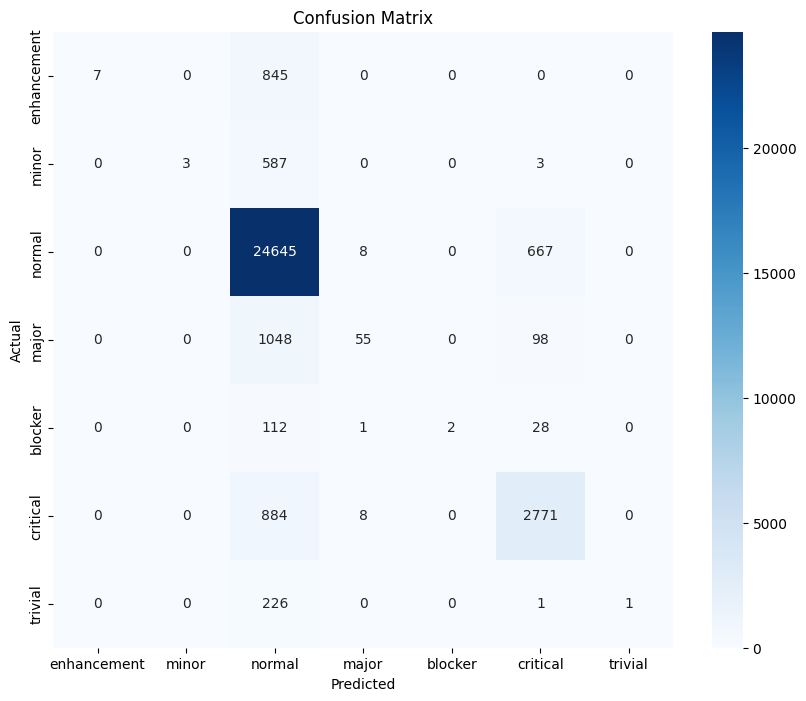

In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

y_pred = xgb_model.predict(X_test)

# Evaluate the model
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred, target_names=severity_mapping.keys())

print(f'Macro-Average Precision: {precision:.4f}')
print(f'Macro-Average Recall: {recall:.4f}')
print(f'Macro-Average F1-Score: {f1:.4f}')
print('\nClassification Report:\n', report)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=severity_mapping.keys(), yticklabels=severity_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Plotting ROC and PR curves
---



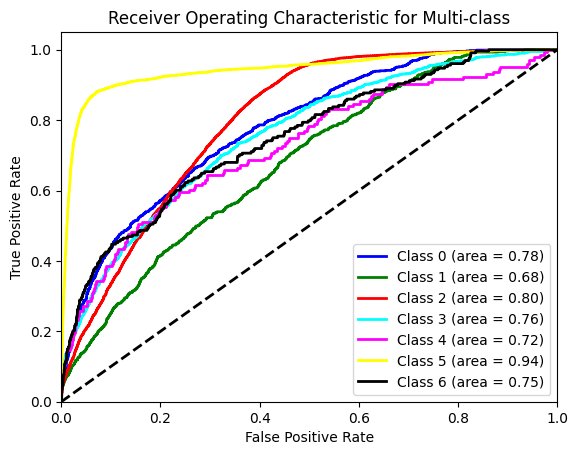

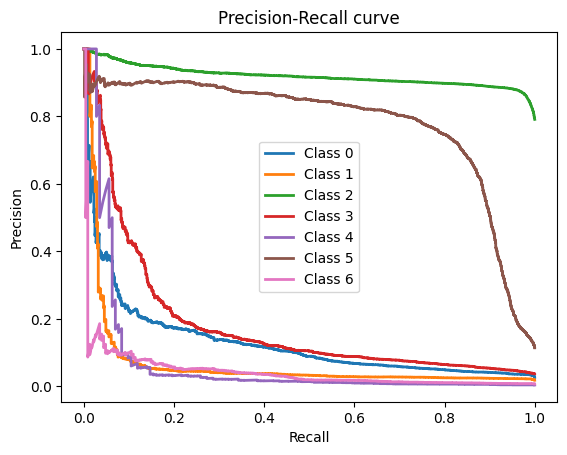

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output for multi-class ROC curve
y_train_binarized = label_binarize(y_train, classes=list(range(len(xgb_model.classes_))))
y_test_binarized = label_binarize(y_test, classes=list(range(len(xgb_model.classes_))))

# Predict probabilities
y_probs = xgb_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(xgb_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])
for i, color in zip(range(len(xgb_model.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-class')
plt.legend(loc="lower right")
plt.show()

# Calculate precision and recall for each class
precision = dict()
recall = dict()
for i in range(len(xgb_model.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_test == i, y_probs[:, i])

# Plotting
for i in range(len(xgb_model.classes_)):
    plt.plot(recall[i], precision[i], lw=2, label='Class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision-Recall curve")
plt.show()

Class mappings are as follows:
0: enhancement
1: minor
2: normal
3: major
4: blocker
5: critical
6: trivial

Retraining the model with the whole data
---

In [ ]:
# Define the XGBoost classifier with optimized parameters
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=133,
    learning_rate=0.06546523848625267,
    max_depth= 8,
    min_child_weight= 2,
    subsample= 0.6180914749645612,
    colsample_bytree= 0.5128901730624544,
    gamma= 1,
    reg_alpha= 4.142601097242927,
    reg_lambda= 0.4582264755684058,
    scale_pos_weight= 4.484533171970974
)

# Train the model
xgb_model.fit(X_train_selected, y)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:11:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5128901730624544, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.06546523848625267, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=133, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

Preprocessing and vectorizing the test data
---


In [ ]:
test_data = pd.read_csv('bugs-test.csv')

# Clean the test data
test_data['cleaned_summary'] = test_data['summary'].apply(clean_text)

# Tokenize the text data for Doc2Vec
test_data['tokens'] = test_data['cleaned_summary'].apply(gensim.utils.simple_preprocess)

# Transform the text data into vectors using Doc2Vec
test_data['doc2vec_vector'] = test_data['tokens'].apply(lambda x: doc2vec_model.infer_vector(x))

# Fill NaN values with an empty string
test_data['cleaned_summary'] = test_data['cleaned_summary'].fillna('')

# Convert all non-string values to strings (just in case)
test_data['cleaned_summary'] = test_data['cleaned_summary'].astype(str)

# Tokenize the text for Word2Vec
tokenized_test_text = [text.split() for text in test_data['cleaned_summary']]

# Function to get average Word2Vec embeddings for a document
test_data['w2v_embeddings'] = test_data['cleaned_summary'].apply(get_w2v_embeddings)

# Vectorize the test data using the same TF-IDF vectorizer
tfidf_test_matrix = tfidf_vectorizer.transform(test_data['cleaned_summary'])
tfidf_test_df = pd.DataFrame(tfidf_test_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Combine all features for the test data
test_combined = pd.concat([pd.DataFrame(test_data['doc2vec_vector'].tolist()),
                           pd.DataFrame(test_data['w2v_embeddings'].tolist()),
                           tfidf_test_df], axis=1, join='inner')

test_combined = test_combined.drop('severity', axis=1)

test_combined.columns = range(test_combined.shape[1])

# Convert X column names to strings
test_combined.columns = test_combined.columns.astype(str)

Predicting the bug severities for the test data with the selected 500 features
---

In [ ]:
# Ensure data is a Numpy array
data_array = test_combined.values if isinstance(test_combined, pd.DataFrame) else test_combined

test_combined_selected = data_array[:, top_500_indices]

# Delete the DataFrame - to free up memory
del data_array

# Run garbage collector
gc.collect()

# Make predictions on the test data
test_predictions = xgb_model.predict(test_combined_selected)

# Reverse severity mapping
reverse_severity_mapping = {v: k for k, v in severity_mapping.items()}

# Map the predictions back to original severity labels
test_data['severity'] = [reverse_severity_mapping[pred] for pred in test_predictions]

# Save the predictions to a CSV file
test_data[['bug_id', 'severity']].to_csv('predictions.csv', index=False)

print("Predictions have been saved to 'predictions.csv'")

Predictions have been saved to 'predictions.csv'


Class distribution of the predicted data
---

In [ ]:
class_distribution = test_data['severity'].value_counts()
print(class_distribution)

severity
normal         77933
critical        8059
major             83
enhancement       12
blocker            5
trivial            2
Name: count, dtype: int64
